In [74]:
# https://arxiv.org/abs/1807.06653
# Invariant Information Clustering for Unsupervised Image Classification and Segmentation

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

$$
\mathbf x, \mathbf x' \in \mathcal X \\
\Phi : \mathcal X \to \mathcal Y
$$

* For example $\mathbf x$ and $\mathbf x'$ could be different images containing the same object ($\mathbf x'$ as an arbitrary augmented data of $\mathbf x$).
* $\mathbf x$ and $\mathbf x'$ are highly correlated, which can be seen as a paired datapoints from a joint probability distribution $P(\mathbf x, \mathbf x')$.
* The goal is to maximize the mutual information ($I$) while discarding instance-specific details.

$$
\max_{\Phi} I(\Phi(\mathbf x), \Phi(\mathbf x'))
$$

In [75]:
logit = torch.randn(8)

proba = logit.softmax(0)
proba_aug = (logit*.5).softmax(0)

print(f"{proba     = }")
print(f"{proba_aug = }")

proba     = tensor([0.0373, 0.4381, 0.0112, 0.0384, 0.0571, 0.0675, 0.1714, 0.1789])
proba_aug = tensor([0.0775, 0.2655, 0.0425, 0.0786, 0.0959, 0.1042, 0.1661, 0.1697])


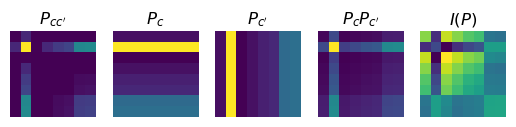

In [82]:
P = proba.reshape(8,1) @ proba_aug.reshape(8,1).T
P = (P + P.T)/2

eps = 0.01
P[P < eps] = eps

Pi = P.sum(dim=1).view(8,1).expand(8,8)
Pj = P.sum(dim=0).view(1,8).expand(8,8)

plt.subplot(1,5,1)
plt.title(r"$P_{cc'}$")
plt.imshow(P)
plt.axis('off')

plt.subplot(1,5,2)
plt.title(r"$P_{c}$")
plt.imshow(Pi)
plt.axis('off')

plt.subplot(1,5,3)
plt.title(r"$P_{c'}$")
plt.imshow(Pj)
plt.axis('off')

plt.subplot(1,5,4)
plt.title(r"$P_{c} P_{c'}$")
plt.imshow(Pi * Pj)
plt.axis('off')

plt.subplot(1,5,5)
plt.title(r"$I(P)$")
plt.imshow(P * (P/(Pi*Pj)).log())
plt.axis('off')
plt.show()

Mutual Information, Clearly Explained - StatQuest (https://youtu.be/eJIp_mgVLwE)

- Joint probability\
Events occuring at the same time

- Marginal probability\
Just the probability of one thing occuring

$$
\begin{array}{ccc}
\hline \hline \textbf{ Likes Popcorn } & \cdots & \textbf { Loves Troll } \\
\hline
\text{ Yes } & \cdots & \text{ Yes } \\
\text{ Yes } & \cdots & \text{ Yes } \\
\text{ Yes } & \cdots & \text{ Yes } \\
\text{ No  } & \cdots & \text{ No  } \\
\text{ No  } & \cdots & \text{ Yes } \\
\hline
\end{array} \\[20pt]

\begin{align*}
&\text{Table 1.1. Contingency table} \\
&\begin{array}{ccc}
\hline \hline & \textbf{ Likes Popcorn } & \textbf{ Dislikes Popcorn } & \Pr(\textbf{ Troll }) \\
\hline
\textbf{ Loves Troll } & {3}/{5} & {1}/{5} & {4}/{5} \\
\textbf{ Hates Troll } & {0}/{5} & {1}/{5} & {1}/{5} \\
\hline
\Pr(\textbf{ Popcorn }) & {3}/{5} & {2}/{5} & \\
\end{array}
\end{align*} \\[20pt]

\begin{align*}
&\text{Table 1.2. Contingency table when independent} \\
&\begin{array}{ccc}
\hline \hline & \textbf{ Likes Popcorn } & \textbf{ Dislikes Popcorn } & \Pr(\textbf{ Troll }) \\
\hline
\textbf{ Loves Troll } & {12}/{25} & {8}/{25} & {4}/{5} \\
\textbf{ Hates Troll } & {3}/{25} & {2}/{25} & {1}/{5} \\
\hline
\Pr(\textbf{ Popcorn }) & {3}/{5} & {2}/{5} & \\
\end{array}
\end{align*}
$$

fun fact : The _marginal probabilities_ are placed in the margins of the table. (Joint probabilities are placed inside of the table)

Mutual information ($I$) can be expressed as:
$$
\begin{align*}
I(X,Y) &= \sum\limits_{x \in X} \sum\limits_{y \in Y} p(x,y) \log \left[ \dfrac{p(x,y)}{p(x)p(y)} \right] \\
&= \dfrac{3}{5} \log \dfrac{{3}/{5}}{{12}/{25}} + \cdots + \dfrac{1}{5} \log \dfrac{{1}/{5}}{{2}/{25}}
\end{align*}
$$

https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0087357